# 🚀 __Classification of Tea Leave Diseases with ResNet-50 (Mindspore - AI Specialization)__
### ☑️ Members: ABADIANO, Aaron; CAPISTRANO, Clara; DE GUZMAN, Rance
***
<div class="alert alert-block alert-success">
<b>Description</b> 

1. Content Brief: 
*  This Jupyter Notebook will exhibit all the source codes in tuning and training the ResNet-50 model for the project's use case.
*  Huawei's Mindspore Framework will be used.

2. Work Environment:
*  Utilized Jupyter Notebook within Jupyter Lab for all coding and analysis.
</div>

In [66]:
from easydict import EasyDict as edict
import os
import numpy as np
import matplotlib.pyplot as plt
import mindspore
import mindspore.dataset as ds
from mindspore.dataset import vision
from mindspore import context
import mindspore.nn as nn
from mindspore.train import Model
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, Callback
from mindspore import Tensor
from mindspore.train.serialization import export
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.ops as ops
import json

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

In [67]:
class LossAccuracyMonitor(Callback):
    def __init__(self, model, eval_dataset, eval_per_epoch=1):
        super(LossAccuracyMonitor, self).__init__()
        self.model = model
        self.eval_dataset = eval_dataset
        self.eval_per_epoch = eval_per_epoch
        self.epoch = 0
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.step_losses = []
        self.step_accs = []

    def on_train_step_end(self, run_context):
        cb_params = run_context.original_args()

        step_loss = cb_params.net_outputs.asnumpy()
        self.step_losses.append(step_loss)

        output = cb_params.net_outputs.asnumpy()
        if output.ndim == 2:
            pred = output.argmax(axis=1)
        else:
            pred = output.argmax(axis=0)
        
        labels = cb_params.train_dataset.create_tuple_iterator().__next__()[1].asnumpy()
        
        step_accuracy = (pred == labels).mean()
        self.step_accs.append(step_accuracy)

    def on_train_epoch_end(self, run_context):
        cb_params = run_context.original_args()
        self.epoch += 1

        avg_train_loss = np.mean(self.step_losses)
        avg_train_acc = np.mean(self.step_accs)
        
        self.train_loss.append(avg_train_loss)
        self.train_acc.append(avg_train_acc)
        
        self.step_losses = []
        self.step_accs = []

        # Evaluate on validation dataset
        if self.epoch % self.eval_per_epoch == 0:
            eval_metrics = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.val_loss.append(eval_metrics["loss"])
            self.val_acc.append(eval_metrics["accuracy"])
            print(f"\tValidation metrics at epoch {self.epoch} - {eval_metrics}")

        print(f"\tTraining metrics at epoch {self.epoch} - Training loss: {avg_train_loss}\n")

    def plot(self):
        epochs = range(1, self.epoch + 1)
        plt.figure(figsize=(8, 6))  # Adjusted figure size to fit a single plot
    
        # Plot loss
        plt.plot(epochs, self.train_loss, label='Training Loss')
        plt.plot(epochs, self.val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
    
        plt.tight_layout()
        plt.show()

In [68]:
cfg = edict({
    'data_path': 'train', # training dataset
    'test_path': 'test', # test dataset
    'data_size': 3616,
    'HEIGHT': 224, 
    'WIDTH': 224, #
    '_R_MEAN': 123.68,
    '_G_MEAN': 116.78,
    '_B_MEAN': 103.94,
    '_R_STD': 1, 
    '_G_STD': 1,
    '_B_STD':1,
    '_RESIZE_SIDE_MIN': 256, 
    '_RESIZE_SIDE_MAX': 512,
    'batch_size': 32,
    'num_class': 8,
    'epoch_size': 10,
    'loss_scale_num':1024,
    'prefix': 'resnet-ai',
    'directory': './model_resnet',
    'save_checkpoint_steps': 10,
})

Number of training datasets:  672
Number of test datasets:  174
Number of channels/Image length/width:  (3, 224, 224)
Label style of an image:  3


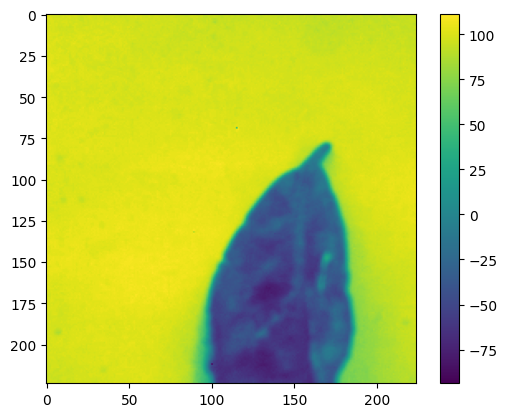

In [69]:
# Data processing
def read_data(path,config,usage="train"):
    dataset = ds.ImageFolderDataset(path,
    class_indexing={'algal_leaf':0,'anthracnose':1,'bird_eye_spot':2,'brown_blight':3,'gray_light':4,'healthy':5,'red_leaf_spot':6, 'white_spot':7})

    decode_op = vision.Decode()
    normalize_op = vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], std=[cfg._R_STD, cfg._G_STD, cfg._B_STD])
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    horizontal_flip_op = vision.RandomHorizontalFlip()
    channelswap_op = vision.HWC2CHW()
    random_crop_decode_resize_op = vision.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), (0.5, 1.0), (1.0, 1.0), max_attempts=100)

    if usage == 'train':
        dataset = dataset.map(input_columns="image", operations=random_crop_decode_resize_op)
        dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)

    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=channelswap_op)

    if usage == 'train':
        dataset = dataset.shuffle(buffer_size=10000)
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    else:
        dataset = dataset.batch(1, drop_remainder=True)
    
    dataset = dataset.repeat(1)
    dataset.map_model = 4
    return dataset

de_train = read_data(cfg.data_path,cfg,usage="train")
de_test = read_data(cfg.test_path,cfg,usage="test")
print('Number of training datasets: ',de_train.get_dataset_size()*cfg.batch_size)
print('Number of test datasets: ',de_test.get_dataset_size())

# Display the sample graph of the training set.
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('Number of channels/Image length/width: ', data_next['image'][0,...].shape)
print('Label style of an image: ', data_next['label'][0])

plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

Image Tensor: (32, 3, 224, 224)
Image Labels: [5 2 0 5 1 7 1 2 6 4 4 5 3 7 2 3 0 3 3 0 3 6 6 5 5 7 0 7 1 2 6 5]


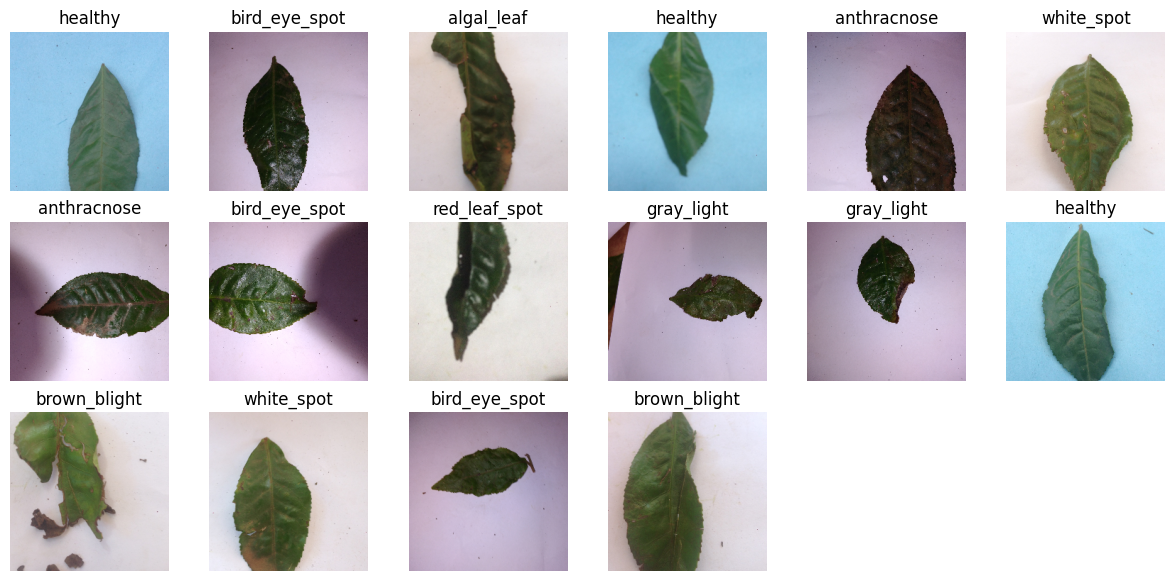

In [70]:
# Display random images with their labels
data = next(de_train.create_dict_iterator(output_numpy=True))
images = data["image"]
labels = data["label"]

print("Image Tensor:", images.shape)
print("Image Labels:", labels)

class_name = {0:'algal_leaf',1:'anthracnose',2:'bird_eye_spot',3:'brown_blight',4:'gray_light',5:'healthy',6:'red_leaf_spot',7:'white_spot'}
plt.figure(figsize=(15, 7))

for i in range(16):
    data_image = images[i].transpose((1, 2, 0)) 
    mean = np.array([cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN]) / 255.0
    std = np.array([cfg._R_STD, cfg._G_STD, cfg._B_STD]) / 255.0
    data_image = data_image * std + mean
    data_image = np.clip(data_image, 0, 1)
    
    plt.subplot(3, 6, i + 1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i])])
    plt.axis("off")
plt.show()

In [71]:
"""ResNet."""

# Define the weight initialization function.
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)
    
# Define the 3x3 convolution layer functions.
def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
    kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)
    
# Define the 1x1 convolution layer functions.
def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
    kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)
    
# Define the 7x7 convolution layer functions.
def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
    kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)
    
# Define the Batch Norm layer functions.
def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
    gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)

In [72]:
# Define the Batch Norm functions at the last layer.
def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
    gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)
    
# Define the functions of the fully-connected layers.
def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)
    
# Construct a residual module.
class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.
    Args:
    in_channel (int): Input channel.
    out_channel (int): Output channel.
    stride (int): Stride size for the first convolutional layer. Default: 1.
    Returns:
    Tensor, output tensor.
    Examples:
    >>> ResidualBlock(3, 256, stride=2)
    """
    expansion = 4 # In conv2_x--conv5_x, the number of convolution kernels at the first two layers is one fourth of the number of convolution kernels at the third layer (an output channel).
    
    def __init__(self, in_channel, out_channel, stride=1):
        super(ResidualBlock, self).__init__()
        # The number of convolution kernels at the first two layers is equal to a quarter of the number of convolution kernels at the output channels.
        channel = out_channel // self.expansion
        # Layer 1 convolution
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)
        # Layer 2 convolution
        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)
        # Layer 3 convolution. The number of convolution kernels is equal to that of output channels.
        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)
        # ReLU activation layer
        self.relu = nn.ReLU()
        self.down_sample = False
    
        # When the step is not 1 or the number of output channels is not equal to that of input channels, downsampling is performed to adjust the number of channels.
        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None
        # Adjust the number of channels using the 1x1 convolution.
        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride), # 1x1 convolution
            _bn(out_channel)]) # Batch Norm
        # Addition operator
        self.add = ops.Add()
    
    # Construct a residual block.
    def construct(self, x):
        # Input
        identity = x
        # Layer 1 convolution 1x1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Layer 2 convolution 3x3
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # Layer 3 convolution 1x1
        out = self.conv3(out)
        out = self.bn3(out)
        # Change the network dimension.
        if self.down_sample:
            identity = self.down_sample_layer(identity)
        # Add the residual.
        out = self.add(out, identity)
        # ReLU activation
        out = self.relu(out)
        return out

# Construct a residual network.
class ResNet(nn.Cell):
    """
    ResNet architecture.
    Args:
    block (Cell): Block for network.
    layer_nums (list): Numbers of block in different layers.
    in_channels (list): Input channel in each layer.
    out_channels (list): Output channel in each layer.
    strides (list): Stride size in each layer.
    num_classes (int): The number of classes that the training images belong to.
        Returns:
    Tensor, output tensor.
    Examples:
    >>> ResNet(ResidualBlock,
    >>> [3, 4, 6, 3],
    >>> [64, 256, 512, 1024],
    >>> [256, 512, 1024, 2048],
    >>> [1, 2, 2, 2],
    >>> 10)
    """
    # Input parameters: residual block, number of repeated residual blocks, input channel, output channel, stride, and number of image classes
    def __init__(self, block, layer_nums, in_channels, out_channels, strides, num_classes):
        super(ResNet, self).__init__()
        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the lgthen of layer_num, in_channels, out_channels list must be 4!")
            
        # Layer 1 convolution; convolution kernels: 7x7, input channels: 3; output channels: 64; step: 2
        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()
        # 3x3 pooling layer; step: 2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")
        # conv2_x residual block
        self.layer1 = self._make_layer(block,
        layer_nums[0],
        in_channel=in_channels[0],
        out_channel=out_channels[0],
        stride=strides[0])
        # conv3_x residual block
        self.layer2 = self._make_layer(block,
        layer_nums[1],
        in_channel=in_channels[1],
        out_channel=out_channels[1],
        stride=strides[1])
        # conv4_x residual block
        self.layer3 = self._make_layer(block,
        layer_nums[2],
        in_channel=in_channels[2],
        out_channel=out_channels[2],
        stride=strides[2])
        # conv5_x residual block
        self.layer4 = self._make_layer(block,
        layer_nums[3],
        in_channel=in_channels[3],
        out_channel=out_channels[3],
        stride=strides[3])
        # Mean operator
        self.mean = ops.ReduceMean(keep_dims=True)
        # Flatten layer
        self.flatten = nn.Flatten()
        # Output layer
        self.end_point = _fc(out_channels[3], num_classes)

    # Input parameters: residual block, number of repeated residual blocks, input channel, output channel, and stride
    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.
        Args:
        block (Cell): Resnet block.
        layer_num (int): Layer number.
        in_channel (int): Input channel.
        out_channel (int): Output channel.
        stride (int): Stride size for the first convolutional layer.
        Returns:
        SequentialCell, the output layer.
        Examples:
        >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
        """
        # Build the residual block of convn_x.
        layers = []
        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)
        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)
        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv1(x) # Layer 1 convolution: 7x7; step: 2
        x = self.bn1(x) # Batch Norm of layer 1
        x = self.relu(x) # ReLU activation layer
        c1 = self.maxpool(x) # Max pooling: 3x3; step: 2
        c2 = self.layer1(c1) # conv2_x residual block
        c3 = self.layer2(c2) # conv3_x residual block
        c4 = self.layer3(c3) # conv4_x residual block
        c5 = self.layer4(c4) # conv5_x residual block
        out = self.mean(c5, (2, 3)) # Mean pooling layer
        out = self.flatten(out) # Flatten layer
        out = self.end_point(out) # Output layer
        return out

    # Build a ResNet-50 network.
def resnet50(class_num=2):
    """
    Get ResNet50 neural network.
    Args:
    class_num (int): Class number.
    Returns:
    Cell, cell instance of ResNet50 neural network.
    Examples:
    >>> net = resnet50(10)
    """
    return ResNet(ResidualBlock, # Residual block
        [3, 4, 6, 3], # Number of residual blocks
        [64, 256, 512, 1024], # Input channel
        [256, 512, 1024, 2048], # Output channel
        [1, 2, 2, 2], # Step
        class_num) # Number of output classes

<div class="alert alert-block alert-warning">
<b>ResNet-50 Model Training</b> 
</div>

In [73]:

net=resnet50(class_num=cfg.num_class)

param_dict = load_checkpoint("resnet50_ascend_v170_cifar10_official_cv_top1acc91.00.ckpt")
# print(param_dict)

new_class_num = cfg.num_class

if "end_point.weight" in param_dict and "end_point.bias" in param_dict:
    old_weight = param_dict["end_point.weight"].asnumpy()
    old_bias = param_dict["end_point.bias"].asnumpy()
    
    new_weight = old_weight[:new_class_num, :]
    new_bias = old_bias[:new_class_num]
    
    param_dict["end_point.weight"] = mindspore.Parameter(Tensor(new_weight, mindspore.float32), name="end_point.weight")
    param_dict["end_point.bias"] = mindspore.Parameter(Tensor(new_bias, mindspore.float32), name="end_point.bias")
else:
    raise KeyError("The keys 'end_point.weight' and 'end_point.bias' were not found in the param_dict. Check the exact layer names.")

load_param_into_net(net, param_dict)

loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

train_step_size = de_train.get_dataset_size()
lr = nn.cosine_decay_lr(min_lr=0.0001, max_lr=0.001, total_step=train_step_size * cfg.epoch_size,step_per_epoch=train_step_size, decay_epoch=cfg.epoch_size)

opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)

loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'accuracy', 'loss'})

loss_cb = LossMonitor(per_print_times=1)

ckpt_config = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps, keep_checkpoint_max=1)

ckpoint_cb = ModelCheckpoint(prefix=cfg.prefix, directory=cfg.directory, config=ckpt_config)

monitor_cb = LossAccuracyMonitor(model, de_test, eval_per_epoch=1)

In [74]:
print("============== Starting Training ==============")

model.fit(cfg.epoch_size, de_train, de_test, callbacks=[loss_cb,ckpoint_cb,monitor_cb], dataset_sink_mode=True)

============== Starting Training ==============
epoch: 1 step: 1, loss is 8.88243579864502
epoch: 1 step: 2, loss is 7.30679988861084
epoch: 1 step: 3, loss is 6.057971954345703
epoch: 1 step: 4, loss is 5.304939270019531
epoch: 1 step: 5, loss is 3.8521528244018555
epoch: 1 step: 6, loss is 3.772969961166382
epoch: 1 step: 7, loss is 3.4485368728637695
epoch: 1 step: 8, loss is 3.5982794761657715
epoch: 1 step: 9, loss is 2.064596652984619
epoch: 1 step: 10, loss is 1.9206360578536987
epoch: 1 step: 11, loss is 0.989924430847168
epoch: 1 step: 12, loss is 2.0639283657073975
epoch: 1 step: 13, loss is 1.9733740091323853
epoch: 1 step: 14, loss is 2.1152143478393555
epoch: 1 step: 15, loss is 1.0862785577774048
epoch: 1 step: 16, loss is 0.9164441227912903
epoch: 1 step: 17, loss is 1.1133677959442139
epoch: 1 step: 18, loss is 1.8837555646896362
epoch: 1 step: 19, loss is 1.198121428489685
epoch: 1 step: 20, loss is 0.8604278564453125
epoch: 1 step: 21, loss is 1.5806596279144287
Eval 

In [75]:
# Use the test set to validate the model and output the accuracy of the test set.
metric = model.eval(de_test)
print(metric)

{'loss': np.float32(0.36536628), 'accuracy': np.float64(0.867816091954023)}


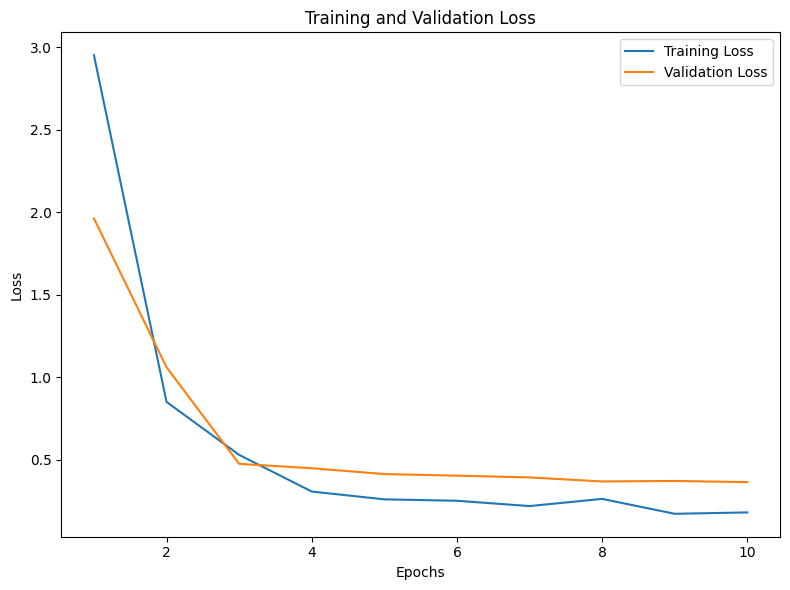

In [76]:
# Plot training and validation loss
monitor_cb.plot()

In [77]:
# Select 10 samples from the test set for testing and output the prediction result and actual result.
class_names = {0:'algal_leaf',1:'anthracnose',2:'bird_eye_spot',3:'brown_blight',4:'gray_light',5:'healthy',6:'red_leaf_spot',7:'white_spot'}
for i in range(10):
    test_ = de_test.create_dict_iterator().__next__()
    test = Tensor(test_['image'], mindspore.float32)

    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()

    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
    print('PREDICTION RESULT FOR IMAGE NUMBER #' + str(i) + " :", class_names[pre_label], '\n\t\t         ACTUAL RESULT: ' + class_names[true_label[0]] + "\n")

PREDICTION RESULT FOR IMAGE NUMBER #0 : bird_eye_spot 
		         ACTUAL RESULT: bird_eye_spot

PREDICTION RESULT FOR IMAGE NUMBER #1 : algal_leaf 
		         ACTUAL RESULT: algal_leaf

PREDICTION RESULT FOR IMAGE NUMBER #2 : brown_blight 
		         ACTUAL RESULT: brown_blight

PREDICTION RESULT FOR IMAGE NUMBER #3 : red_leaf_spot 
		         ACTUAL RESULT: red_leaf_spot

PREDICTION RESULT FOR IMAGE NUMBER #4 : algal_leaf 
		         ACTUAL RESULT: algal_leaf

PREDICTION RESULT FOR IMAGE NUMBER #5 : red_leaf_spot 
		         ACTUAL RESULT: red_leaf_spot

PREDICTION RESULT FOR IMAGE NUMBER #6 : gray_light 
		         ACTUAL RESULT: gray_light

PREDICTION RESULT FOR IMAGE NUMBER #7 : red_leaf_spot 
		         ACTUAL RESULT: red_leaf_spot

PREDICTION RESULT FOR IMAGE NUMBER #8 : red_leaf_spot 
		         ACTUAL RESULT: red_leaf_spot

PREDICTION RESULT FOR IMAGE NUMBER #9 : algal_leaf 
		         ACTUAL RESULT: algal_leaf



Image #0 Tensor: (1, 3, 224, 224)
Image #0 Label: [5]
Image #1 Tensor: (1, 3, 224, 224)
Image #1 Label: [4]
Image #2 Tensor: (1, 3, 224, 224)
Image #2 Label: [6]
Image #3 Tensor: (1, 3, 224, 224)
Image #3 Label: [6]
Image #4 Tensor: (1, 3, 224, 224)
Image #4 Label: [0]
Image #5 Tensor: (1, 3, 224, 224)
Image #5 Label: [7]
Image #6 Tensor: (1, 3, 224, 224)
Image #6 Label: [1]
Image #7 Tensor: (1, 3, 224, 224)
Image #7 Label: [7]
Image #8 Tensor: (1, 3, 224, 224)
Image #8 Label: [7]
Image #9 Tensor: (1, 3, 224, 224)
Image #9 Label: [3]


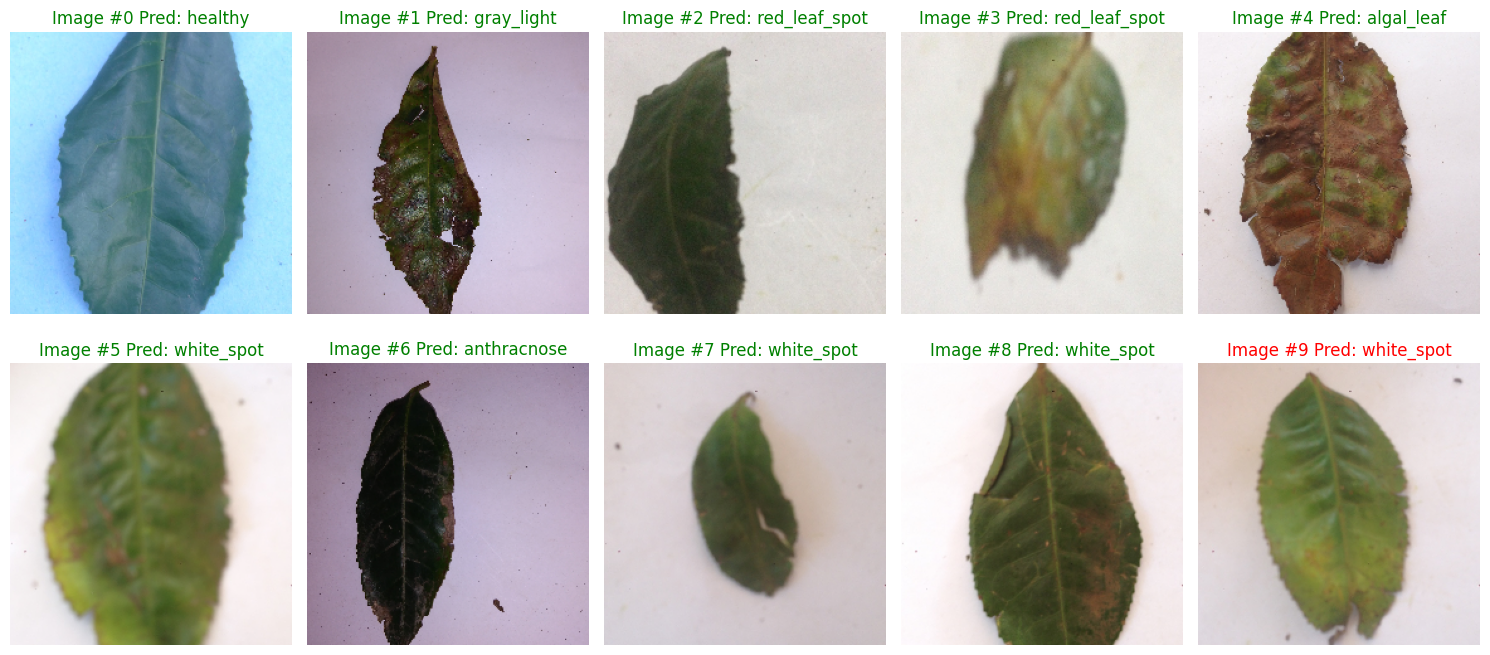

In [78]:
# Select 10 samples from the test set for testing and output the prediction result and actual result.
def visualize_predictions(model, dataset, class_names):
    plt.figure(figsize=(15, 7))
    
    for i, data in enumerate(dataset.create_dict_iterator(output_numpy=True)):
        if i >= 10:
            break
        
        image = data["image"]
        label = data["label"]
        prediction = model.predict(Tensor(image, mindspore.float32)).asnumpy()
        predicted_label = np.argmax(prediction, axis=1)

        print(f"Image #{i} Tensor:", image.shape)
        print(f"Image #{i} Label:", label)
        
        image = image.transpose((0, 2, 3, 1))  # Transpose to (N, H, W, C)
        mean = np.array([cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN]) / 255.0
        std = np.array([cfg._R_STD, cfg._G_STD, cfg._B_STD]) / 255.0
        image = (image * std + mean).clip(0, 1)
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(image[0])
        color = 'green' if predicted_label[0] == label[0] else 'red'
        plt.title(f"Image #{i} Pred: {class_names[predicted_label[0]]}", color=color)
        plt.xlabel(f"#{i} Actual: {class_names[label[0]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

class_names = {0:'algal_leaf',1:'anthracnose',2:'bird_eye_spot',3:'brown_blight',4:'gray_light',5:'healthy',6:'red_leaf_spot',7:'white_spot'}

# Visualize predictions
visualize_predictions(model, de_test, class_names)

In [59]:
from sklearn.metrics import confusion_matrix

In [80]:
net = resnet50(class_num=cfg['num_class'])
param_dict = load_checkpoint('model_resnet/resnet-ai_2-10_21.ckpt')
load_param_into_net(net, param_dict)

model = Model(net)

num_classes = cfg['num_class']
conf_matrix = nn.ConfusionMatrix(num_classes=num_classes, normalize='no_norm', threshold=0.5)

conf_matrix.clear()

for data in de_test.create_tuple_iterator():
    images, true_labels = data
    pred_logits = model.predict(images)
    pred_labels = pred_logits.argmax(axis=1)

    conf_matrix.update(pred_labels, true_labels)

# confusion matrix using mindspore
output = conf_matrix.eval()
print("Confusion Matrix:\n", output)

true_labels_list = []
pred_labels_list = []

for data in de_test.create_tuple_iterator():
    images, true_labels = data
    pred_logits = model.predict(images)
    pred_labels = pred_logits.argmax(axis=1)

    true_labels_list.extend(true_labels.asnumpy())
    pred_labels_list.extend(pred_labels.asnumpy())

# confusion matrix using scikit-learn
cm = confusion_matrix(true_labels_list, pred_labels_list)
print("Confusion Matrix (sklearn):\n", cm)

Confusion Matrix:
 [[22.  0.  0.  0.  0.  0.  0.  1.]
 [ 0. 12.  2.  0.  6.  0.  0.  0.]
 [ 0.  2. 16.  0.  2.  0.  0.  0.]
 [ 1.  0.  0. 15.  0.  0.  1.  3.]
 [ 0.  2.  1.  0. 17.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 15.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 28.  0.]
 [ 0.  0.  0.  2.  0.  0.  0. 26.]]
Confusion Matrix (sklearn):
 [[22  0  0  0  0  0  0  1]
 [ 0 12  2  0  6  0  0  0]
 [ 0  2 16  0  2  0  0  0]
 [ 1  0  0 15  0  0  1  3]
 [ 0  2  1  0 17  0  0  0]
 [ 0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 28  0]
 [ 0  0  0  2  0  0  0 26]]


In [81]:
import seaborn as sns

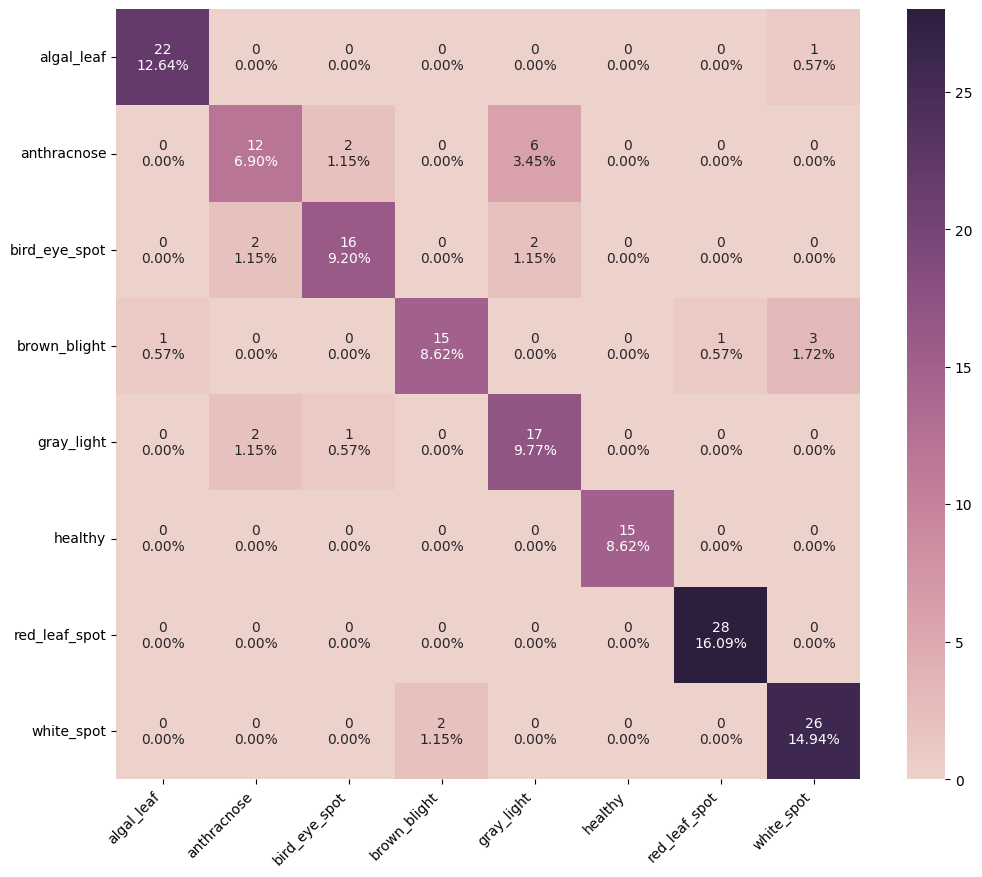

In [82]:

class_names = [
    'algal_leaf', 'anthracnose', 'bird_eye_spot', 'brown_blight',
    'gray_light', 'healthy', 'red_leaf_spot', 'white_spot'
]

group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]

labels = [f'{count}\n{percent}' for count, percent in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(8, 8)

fig, ax = plt.subplots(figsize=(12, 10))
conf_matx = sns.heatmap(cm, annot=labels, fmt='', cmap=sns.cubehelix_palette(as_cmap=True))

conf_matx.set_xticks(np.arange(len(class_names)) + 0.5)
conf_matx.set_xticklabels(class_names, rotation=45, ha="right")
conf_matx.set_yticks(np.arange(len(class_names)) + 0.5)
conf_matx.set_yticklabels(class_names, rotation=0)
conf_matx.xaxis.tick_bottom()
conf_matx.yaxis.tick_left()

plt.show()


In [83]:
monitor_cb.val_acc

[np.float64(0.632183908045977),
 np.float64(0.7126436781609196),
 np.float64(0.8563218390804598),
 np.float64(0.867816091954023),
 np.float64(0.8563218390804598),
 np.float64(0.8505747126436781),
 np.float64(0.8448275862068966),
 np.float64(0.8505747126436781),
 np.float64(0.867816091954023),
 np.float64(0.867816091954023)]

In [84]:
monitor_cb.train_acc

[np.float64(0.13690476190476192),
 np.float64(0.1324404761904762),
 np.float64(0.12797619047619047),
 np.float64(0.15773809523809523),
 np.float64(0.1324404761904762),
 np.float64(0.09523809523809523),
 np.float64(0.14583333333333334),
 np.float64(0.13392857142857142),
 np.float64(0.11458333333333333),
 np.float64(0.13541666666666666)]

In [85]:
monitor_cb.val_loss

[np.float32(1.9629275),
 np.float32(1.0616903),
 np.float32(0.47607294),
 np.float32(0.44959503),
 np.float32(0.41422656),
 np.float32(0.40465954),
 np.float32(0.39402393),
 np.float32(0.3693909),
 np.float32(0.37251383),
 np.float32(0.3653663)]

In [86]:
monitor_cb.train_loss

[np.float32(2.9519436),
 np.float32(0.8514642),
 np.float32(0.53055966),
 np.float32(0.30843815),
 np.float32(0.26113036),
 np.float32(0.25244984),
 np.float32(0.22026865),
 np.float32(0.26387495),
 np.float32(0.17354572),
 np.float32(0.18188074)]